In [14]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
def V_morse(x):
    D = 0.1744 # 4.7457 eV
    beta = 1.02764 # 1.94196e10 m-1
    x_e = 1.40201 # 0.74191e-10 m

    return D*(1-np.exp(-beta*(x-x_e)))**2

def V_ho(x):
    return 0.5*x**2

def fgh(V, x_grid, m):
    
    N = x_grid.size
    delta_x = x_grid[1] - x_grid[0]
    xmax = x_grid[-1]

    H = np.zeros((N,N))

    T_k = np.zeros(N)
    for n in range(0,N):
        T_k[n] = 2/m * (np.pi*(n-(N-1)/2.0)/(xmax))**2
    T_k = np.fft.fftshift(T_k)

    for n in range(0,N):

        phi_n = np.zeros(N)
        phi_n[n] = 1

        V_phi_n = np.zeros(N)
        V_phi_n[n] = V(x_grid[n])

        # fast fourier transform
        F_phi_n = np.fft.fft(phi_n) # into k-space
        TF_phi_n = np.multiply(T_k, F_phi_n)
        T_phi_n = np.fft.ifft(TF_phi_n) # not sure if this is necessary

        H[:,n] = T_phi_n + V_phi_n

    # diagonalize
    E, psi = np.linalg.eig(H)
    E = np.real(E)

    # sort energies in increasing order
    ind = np.argsort(E)
    E = E[ind]
    psi = psi[:,ind]

    print(E[0:20])
    plt.plot(E[0:20])
    
    plt.plot(x_grid,psi[:,5])
    plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


[  0.20921676   0.37839991   0.46825468   0.97638314   1.07111552
   1.97177228   2.05203504   3.36050926   3.4259374    5.14227426
   5.19611604   7.31745776   7.36268821   9.88646002   9.92525524
  12.84957378  12.88345776  16.2069969   16.23704168  19.95886152]


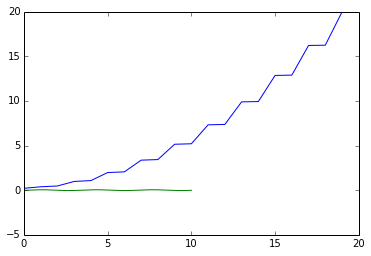

[ 0.00993532  0.02883393  0.04657987  0.06317313  0.07861371  0.09290161
  0.10603683  0.11801937  0.12884923  0.13852642  0.14705092  0.15442275
  0.16064189  0.16570836  0.16962215  0.17238327  0.17399917  0.17484764
  0.17587548  0.17720675]


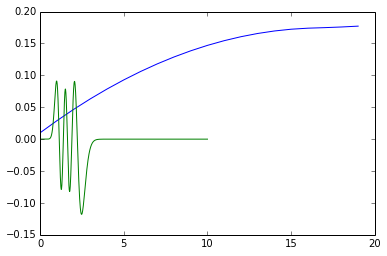

In [16]:
x_grid = np.linspace(0,10,1000)

#plt.plot(x_grid,V_morse(x_grid)/0.1744)
#plt.show()
fgh(V_morse,x_grid,1)
fgh(V_morse,x_grid,1836/2.0)